# #DATA MANIPULATION #FEATURE ENGINEERING

In [1]:
import warnings
warnings.simplefilter(action='ignore')
import pandas as pd  
import os.path as osp
import os
import logging
from glob import glob
import numpy as np
import re   
import plotnine as pln
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

In [2]:
DATA_DIR = "tennis_data"
ATP_DIR = './{}/ATP'.format(DATA_DIR)
ATP_FILES = sorted(glob("%s/*.xls*" % ATP_DIR))
df_atp = pd.concat([pd.read_excel(f) for f in ATP_FILES], ignore_index=True,sort=True)

In [47]:
winnersCount = df_atp['Winner'].value_counts()

In [48]:
# Find the players with the most wins
winnersCount.sort_values(ascending=False).head(10)

Djokovic N.     237
Nadal R.        212
Thiem D.        192
Federer R.      187
Nishikori K.    180
Zverev A.       170
Murray A.       167
Cilic M.        163
Goffin D.       160
Raonic M.       148
Name: Winner, dtype: int64

# Data Preparation
## Data Splitting

We start first by selecting the rows we're going to use, they belong to 4 categories :  
1 - Location and organisation related features ( Tournament, Series, Date, Round)  
2 - Game field related data (Surface, Court)  
3 - Players' performances (LPts, WPts, WRank, LRank)  
4 - Average betting data (AvgW, AvgL)  

In [49]:
usedColumns = ['Best of',
'Court',
'Date',
'LPts',
 'LRank',
'Loser',
 'Round',
 'Series',
 'Surface',
 'Tournament',
'WPts',
 'WRank',
 'Winner']

In [50]:
gTest = lambda x: x.year == 2019
gTrain = lambda x: x.year < 2019
testInd = df_atp['Date'].apply(gTest)
trainInd = df_atp['Date'].apply(gTrain)

In [51]:
#split the date in train and test
#for 2019 I let just the Australian Open Matches
df_atp_Train = df_atp.loc[trainInd, usedColumns].copy()
df_atp_Test = df_atp.loc[testInd, usedColumns].copy()

## Feature Engineering  
### Output modeling  
If we define the outcome of a match as the 'Winner's name', the problem would be a multi-classification task with an output taking labels belonging to the names of all players since 2000. This approach is not realistic since for each match we have two players and the winner is among them. One way to explore that is to consider two aditionnal features 'player1' and 'player2' to which we randomly assign the match winner and loser, the target variable would belong to the couple (0,1) and the problem can be treated as a **binary classification** learning.

In [71]:
df_atp_Train[['Player1','Player2']] = df_atp_Train.loc[:,['Winner','Loser']]
df_atp_Train.head()

,Best of,Court,Date,LPts,LRank,Loser,Round,Series,Surface,Tournament,WPts,WRank,Winner,Player1,Player2
0,3,Outdoor,2015-01-05,1730.0,21.0,Simon G.,1st Round,ATP250,Hard,Brisbane International,430.0,125.0,Duckworth J.,Duckworth J.,Simon G.
1,3,Outdoor,2015-01-05,1365.0,25.0,Benneteau J.,1st Round,ATP250,Hard,Brisbane International,341.0,149.0,Kokkinakis T.,Kokkinakis T.,Benneteau J.
2,3,Outdoor,2015-01-05,691.0,72.0,Golubev A.,1st Round,ATP250,Hard,Brisbane International,1195.0,31.0,Chardy J.,Chardy J.,Golubev A.
3,3,Outdoor,2015-01-05,1090.0,35.0,Querrey S.,1st Round,ATP250,Hard,Brisbane International,797.0,53.0,Tomic B.,Tomic B.,Querrey S.
4,3,Outdoor,2015-01-06,242.0,201.0,Copil M.,1st Round,ATP250,Hard,Brisbane International,705.0,69.0,Kukushkin M.,Kukushkin M.,Copil M.


In [72]:
np.random.seed(1995)

In [73]:
Won = np.random.randint(2,size=len(df_atp_Train))

In [74]:
df_atp_Train['Won'] = Won
boolWon = (Won==0)

In [75]:
df_atp_Train.loc[boolWon,'Player1'] , df_atp_Train.loc[boolWon,'Player2'] = df_atp_Train.loc[boolWon,'Player2'], df_atp_Train.loc[boolWon,'Player1']

In [76]:
df_atp_Train.head()

,Best of,Court,Date,LPts,LRank,Loser,Round,Series,Surface,Tournament,WPts,WRank,Winner,Player1,Player2,Won
0,3,Outdoor,2015-01-05,1730.0,21.0,Simon G.,1st Round,ATP250,Hard,Brisbane International,430.0,125.0,Duckworth J.,Simon G.,Duckworth J.,0
1,3,Outdoor,2015-01-05,1365.0,25.0,Benneteau J.,1st Round,ATP250,Hard,Brisbane International,341.0,149.0,Kokkinakis T.,Benneteau J.,Kokkinakis T.,0
2,3,Outdoor,2015-01-05,691.0,72.0,Golubev A.,1st Round,ATP250,Hard,Brisbane International,1195.0,31.0,Chardy J.,Golubev A.,Chardy J.,0
3,3,Outdoor,2015-01-05,1090.0,35.0,Querrey S.,1st Round,ATP250,Hard,Brisbane International,797.0,53.0,Tomic B.,Tomic B.,Querrey S.,1
4,3,Outdoor,2015-01-06,242.0,201.0,Copil M.,1st Round,ATP250,Hard,Brisbane International,705.0,69.0,Kukushkin M.,Kukushkin M.,Copil M.,1


We do the same for the test set.

In [77]:
df_atp_Test[['Player1','Player2']] = df_atp_Test.loc[:,['Winner','Loser']]
df_atp_Test.head()

,Best of,Court,Date,LPts,LRank,Loser,Round,Series,Surface,Tournament,WPts,WRank,Winner,Player1,Player2
10526,5,Outdoor,2019-01-14,1045.0,42.0,Mannarino A.,1st Round,Grand Slam,Hard,Australian Open,4810.0,6.0,Anderson K.,Anderson K.,Mannarino A.
10527,5,Outdoor,2019-01-14,312.0,170.0,Eubanks C.,1st Round,Grand Slam,Hard,Australian Open,1820.0,20.0,Basilashvili N.,Basilashvili N.,Eubanks C.
10528,5,Outdoor,2019-01-14,526.0,107.0,Mmoh M.,1st Round,Grand Slam,Hard,Australian Open,585.0,98.0,Albot R.,Albot R.,Mmoh M.
10529,5,Outdoor,2019-01-14,708.0,77.0,Andreozzi G.,1st Round,Grand Slam,Hard,Australian Open,401.0,137.0,Travaglia S.,Travaglia S.,Andreozzi G.
10530,5,Outdoor,2019-01-14,458.0,125.0,Kecmanovic M.,1st Round,Grand Slam,Hard,Australian Open,1410.0,28.0,Verdasco F.,Verdasco F.,Kecmanovic M.


In [78]:
WonT = np.random.randint(2,size=len(df_atp_Test))
boolWonT = (WonT==0)
df_atp_Test['Won'] = WonT

In [79]:
df_atp_Test.head()

,Best of,Court,Date,LPts,LRank,Loser,Round,Series,Surface,Tournament,WPts,WRank,Winner,Player1,Player2,Won
10526,5,Outdoor,2019-01-14,1045.0,42.0,Mannarino A.,1st Round,Grand Slam,Hard,Australian Open,4810.0,6.0,Anderson K.,Anderson K.,Mannarino A.,1
10527,5,Outdoor,2019-01-14,312.0,170.0,Eubanks C.,1st Round,Grand Slam,Hard,Australian Open,1820.0,20.0,Basilashvili N.,Basilashvili N.,Eubanks C.,0
10528,5,Outdoor,2019-01-14,526.0,107.0,Mmoh M.,1st Round,Grand Slam,Hard,Australian Open,585.0,98.0,Albot R.,Albot R.,Mmoh M.,1
10529,5,Outdoor,2019-01-14,708.0,77.0,Andreozzi G.,1st Round,Grand Slam,Hard,Australian Open,401.0,137.0,Travaglia S.,Travaglia S.,Andreozzi G.,1
10530,5,Outdoor,2019-01-14,458.0,125.0,Kecmanovic M.,1st Round,Grand Slam,Hard,Australian Open,1410.0,28.0,Verdasco F.,Verdasco F.,Kecmanovic M.,0


In [80]:
df_atp_Test.loc[boolWonT,'Player1'] , df_atp_Test.loc[boolWonT,'Player2'] = df_atp_Test.loc[boolWonT,'Player2'], df_atp_Test.loc[boolWonT,'Player1']

In [81]:
df_atp_Test.head()

,Best of,Court,Date,LPts,LRank,Loser,Round,Series,Surface,Tournament,WPts,WRank,Winner,Player1,Player2,Won
10526,5,Outdoor,2019-01-14,1045.0,42.0,Mannarino A.,1st Round,Grand Slam,Hard,Australian Open,4810.0,6.0,Anderson K.,Anderson K.,Mannarino A.,1
10527,5,Outdoor,2019-01-14,312.0,170.0,Eubanks C.,1st Round,Grand Slam,Hard,Australian Open,1820.0,20.0,Basilashvili N.,Eubanks C.,Basilashvili N.,0
10528,5,Outdoor,2019-01-14,526.0,107.0,Mmoh M.,1st Round,Grand Slam,Hard,Australian Open,585.0,98.0,Albot R.,Albot R.,Mmoh M.,1
10529,5,Outdoor,2019-01-14,708.0,77.0,Andreozzi G.,1st Round,Grand Slam,Hard,Australian Open,401.0,137.0,Travaglia S.,Travaglia S.,Andreozzi G.,1
10530,5,Outdoor,2019-01-14,458.0,125.0,Kecmanovic M.,1st Round,Grand Slam,Hard,Australian Open,1410.0,28.0,Verdasco F.,Kecmanovic M.,Verdasco F.,0


### Feature creation  
#### Player1 Vs Player2  
H2H wins variable : count of all times when player1 beated player2 minus the count of all times when player2 beated player1 before the year of the match. 
Return of the next function:
A dataframe with the Winner, Loser, winning rate of the winner in the past (<Year)
The victories are also weighted with the number of Sets played (Best Of).

In [82]:
df_atp_Train['Year'] = df_atp_Train.Date.apply(lambda x : x.year)

In [83]:
df_atp_Test['Year'] = df_atp_Test.Date.apply(lambda x : x.year)

In [85]:
def recordedVs(Year, data, past = 4, includeYear = False):
    pastYears = np.min([past, Year-2015])
    if includeYear:
        includeY = 1
    else:
        includeY = 0
    
    df_sub = data.loc[(Year-pastYears <= data.Year) & (data.Year<Year+includeY),['Best of','Winner','Loser']].copy()
    df_sub['CouplesSet'] = df_sub.apply(lambda x : str(set((x['Winner'], x['Loser']))), axis=1)
    countSets = df_sub.CouplesSet.value_counts()
    countSets = pd.DataFrame({'couplePlayer':countSets.index, 'NMatche':countSets.values})
    countWons = df_sub.groupby(['Winner','Loser'])
    countWons = countWons.aggregate(['count','mean'])
    countWons.reset_index(inplace=True)
    countWons['CountWon'] = countWons.loc[:,('Best of','count')]
    countWons['MeanBestOf'] = countWons.loc[:,('Best of','mean')]
    countWons.drop(axis=1, columns='Best of', level=0, inplace=True)
    countWons['relativeVictory'] = 0.0
    countWIndx = countWons.index
    countSIndx = countSets.index
    
    for i in range(len(countWons)):
        p1 = countWons.loc[countWIndx[i],'Winner'].values[0]
        p2 = countWons.loc[countWIndx[i],'Loser'].values[0]
    
        Nindex = countSIndx[countSets.couplePlayer.apply(lambda x : (p1 in x) & (p2 in x) )]
        N = countSets.loc[Nindex, 'NMatche']
        countWons.loc[countWIndx[i],'relativeVictory'] = np.asscalar(countWons.loc[countWIndx[i],'CountWon']/N.values[0])
    return(countWons)


In [86]:
genHistory = recordedVs(2019, data = df_atp_Train, past = 4, includeYear=True)

/Users/george/Desktop/Anaconda/anaconda3/lib/python3.7/site-packages/numpy/lib/type_check.py:547: FutureWarning: `item` has been deprecated and will be removed in a future version
  return a.item()


In [87]:
genHistoryTest = recordedVs(2019, data = df_atp_Train, past = 1, includeYear=True)

History between Federer and Djokovic

In [89]:
genHistory.loc[(genHistory.Winner == 'Federer R.')&(genHistory.Loser == 'Djokovic N.'),:]

,Winner,Loser,CountWon,MeanBestOf,relativeVictory
,,,,,
2330,Federer R.,Djokovic N.,3,3.0,0.272727


Now we can fill the values for the new features 'p1Vsp2' and 'Wp1Vsp2' based on the records in the 'genHistory' dataset.

In [90]:
df_atp_Train['p1Vsp2'] = 0
df_atp_Train['Wp1Vsp2'] = 0

In [91]:
def p1Vsp2(data, history = genHistory):

    dataIndex = data.index
    dataLenght = len(data)

    for i in dataIndex:
        p1 = data.loc[i,'Player1']
        p2 = data.loc[i,'Player2']
        relVict = history.loc[((history.Winner==p1) & (history.Loser==p2)),'relativeVictory' ]
        relLoss = history.loc[((history.Winner==p2) & (history.Loser==p1)),'relativeVictory' ]
        
        if len(relVict)==0:
            relVict = 0
        else:
            relVict = np.asscalar(relVict.values)
        if len(relLoss)==0:
            relLoss = 0  
        else:
            relLoss = np.asscalar(relLoss.values)
         
        MeanSetsW = history.loc[((history.Winner==p1) & (history.Loser==p2)),'MeanBestOf' ]
        MeanSetsL = history.loc[((history.Loser==p1) & (history.Winner==p2)),'MeanBestOf' ]
    
        if len(MeanSetsW)==0:
            MeanSetsW = 3
        else:
            MeanSetsW = np.asscalar(MeanSetsW.values)
        if len(MeanSetsL)==0:
            MeanSetsL = 3
        else:
            MeanSetsL = np.asscalar(MeanSetsL.values)
        
        WrelVict = relVict/MeanSetsW
        LrelVict = relLoss/MeanSetsL
    
    
        data.loc[i,'p1Vsp2'] = relVict - relLoss
        data.loc[i,'Wp1Vsp2'] = WrelVict - LrelVict

In [92]:
p1Vsp2(data = df_atp_Train, history = genHistory)
#here I have done a computation progress just to make sure everything it's working ok but then I've deleted it

Computations in progress 0.0%
Computations in progress 10.0%
Computations in progress 20.0%
Computations in progress 30.0%
Computations in progress 40.0%
Computations in progress 50.0%
Computations in progress 60.0%
Computations in progress 70.0%
Computations in progress 80.0%
Computations in progress 90.0%
Computations in progress 100.0%
Done !


In [93]:
df_atp_Train.head()

,Best of,Court,Date,LPts,LRank,Loser,Round,Series,Surface,Tournament,WPts,WRank,Winner,Player1,Player2,Won,Year,p1Vsp2,Wp1Vsp2
0,3,Outdoor,2015-01-05,1730.0,21.0,Simon G.,1st Round,ATP250,Hard,Brisbane International,430.0,125.0,Duckworth J.,Simon G.,Duckworth J.,0,2015,-1.0,-0.333333
1,3,Outdoor,2015-01-05,1365.0,25.0,Benneteau J.,1st Round,ATP250,Hard,Brisbane International,341.0,149.0,Kokkinakis T.,Benneteau J.,Kokkinakis T.,0,2015,-1.0,-0.333333
2,3,Outdoor,2015-01-05,691.0,72.0,Golubev A.,1st Round,ATP250,Hard,Brisbane International,1195.0,31.0,Chardy J.,Golubev A.,Chardy J.,0,2015,-1.0,-0.333333
3,3,Outdoor,2015-01-05,1090.0,35.0,Querrey S.,1st Round,ATP250,Hard,Brisbane International,797.0,53.0,Tomic B.,Tomic B.,Querrey S.,1,2015,1.0,0.333333
4,3,Outdoor,2015-01-06,242.0,201.0,Copil M.,1st Round,ATP250,Hard,Brisbane International,705.0,69.0,Kukushkin M.,Kukushkin M.,Copil M.,1,2015,0.0,0.000000


In [94]:
df_atp_Test['p1Vsp2'] = 0
df_atp_Test['Wp1Vsp2'] = 0

In [95]:
p1Vsp2(data = df_atp_Test, history = genHistoryTest)

Computations in progress 0.0%
Computations in progress 9.0%
Computations in progress 19.0%
Computations in progress 28.0%
Computations in progress 38.0%
Computations in progress 47.0%
Computations in progress 57.0%
Computations in progress 66.0%
Computations in progress 76.0%
Computations in progress 85.0%
Computations in progress 94.0%
Done !


In [96]:
df_atp_Test.head()

,Best of,Court,Date,LPts,LRank,Loser,Round,Series,Surface,Tournament,WPts,WRank,Winner,Player1,Player2,Won,Year,p1Vsp2,Wp1Vsp2
10526,5,Outdoor,2019-01-14,1045.0,42.0,Mannarino A.,1st Round,Grand Slam,Hard,Australian Open,4810.0,6.0,Anderson K.,Anderson K.,Mannarino A.,1,2019,1.0,0.333333
10527,5,Outdoor,2019-01-14,312.0,170.0,Eubanks C.,1st Round,Grand Slam,Hard,Australian Open,1820.0,20.0,Basilashvili N.,Eubanks C.,Basilashvili N.,0,2019,0.0,0.000000
10528,5,Outdoor,2019-01-14,526.0,107.0,Mmoh M.,1st Round,Grand Slam,Hard,Australian Open,585.0,98.0,Albot R.,Albot R.,Mmoh M.,1,2019,0.0,0.000000
10529,5,Outdoor,2019-01-14,708.0,77.0,Andreozzi G.,1st Round,Grand Slam,Hard,Australian Open,401.0,137.0,Travaglia S.,Travaglia S.,Andreozzi G.,1,2019,0.0,0.000000
10530,5,Outdoor,2019-01-14,458.0,125.0,Kecmanovic M.,1st Round,Grand Slam,Hard,Australian Open,1410.0,28.0,Verdasco F.,Kecmanovic M.,Verdasco F.,0,2019,0.0,0.000000


#### Rank and Points differences (Player1 - Player2)    
The two features we're going to introduce are simply the difference between players performances (Points and Ranks).  

In [97]:
df_atp_Train["RankDiff"] = 0
df_atp_Train["PtsDiff"] = 0

In [98]:
def performanceDiff(variable = 'Rank', targetData=df_atp_Train):
    if variable == 'Rank':
        Wval, Lval = 'WRank', 'LRank'
        target = "RankDiff"
        differences = targetData[Lval]-targetData[Wval]
    elif variable == 'Point':
        Wval, Lval = 'WPts', 'LPts'
        target = "PtsDiff"
        differences = targetData[Wval]-targetData[Lval]
    
    targetData[target] = differences
    wonInd1 = targetData['Won'] == 0
    targetData.loc[wonInd1,target] = targetData.loc[wonInd1,target].apply(lambda x : -x)

In [99]:
performanceDiff(variable='Rank', targetData=df_atp_Train)

In [100]:
df_atp_Train.head()

,Best of,Court,Date,LPts,LRank,Loser,Round,Series,Surface,Tournament,...,WRank,Winner,Player1,Player2,Won,Year,p1Vsp2,Wp1Vsp2,RankDiff,PtsDiff
0,3,Outdoor,2015-01-05,1730.0,21.0,Simon G.,1st Round,ATP250,Hard,Brisbane International,...,125.0,Duckworth J.,Simon G.,Duckworth J.,0,2015,-1.0,-0.333333,104.0,0
1,3,Outdoor,2015-01-05,1365.0,25.0,Benneteau J.,1st Round,ATP250,Hard,Brisbane International,...,149.0,Kokkinakis T.,Benneteau J.,Kokkinakis T.,0,2015,-1.0,-0.333333,124.0,0
2,3,Outdoor,2015-01-05,691.0,72.0,Golubev A.,1st Round,ATP250,Hard,Brisbane International,...,31.0,Chardy J.,Golubev A.,Chardy J.,0,2015,-1.0,-0.333333,-41.0,0
3,3,Outdoor,2015-01-05,1090.0,35.0,Querrey S.,1st Round,ATP250,Hard,Brisbane International,...,53.0,Tomic B.,Tomic B.,Querrey S.,1,2015,1.0,0.333333,-18.0,0
4,3,Outdoor,2015-01-06,242.0,201.0,Copil M.,1st Round,ATP250,Hard,Brisbane International,...,69.0,Kukushkin M.,Kukushkin M.,Copil M.,1,2015,0.0,0.000000,132.0,0


In [101]:
performanceDiff(variable='Point', targetData=df_atp_Train)

In [102]:
df_atp_Train.head()

,Best of,Court,Date,LPts,LRank,Loser,Round,Series,Surface,Tournament,...,WRank,Winner,Player1,Player2,Won,Year,p1Vsp2,Wp1Vsp2,RankDiff,PtsDiff
0,3,Outdoor,2015-01-05,1730.0,21.0,Simon G.,1st Round,ATP250,Hard,Brisbane International,...,125.0,Duckworth J.,Simon G.,Duckworth J.,0,2015,-1.0,-0.333333,104.0,1300.0
1,3,Outdoor,2015-01-05,1365.0,25.0,Benneteau J.,1st Round,ATP250,Hard,Brisbane International,...,149.0,Kokkinakis T.,Benneteau J.,Kokkinakis T.,0,2015,-1.0,-0.333333,124.0,1024.0
2,3,Outdoor,2015-01-05,691.0,72.0,Golubev A.,1st Round,ATP250,Hard,Brisbane International,...,31.0,Chardy J.,Golubev A.,Chardy J.,0,2015,-1.0,-0.333333,-41.0,-504.0
3,3,Outdoor,2015-01-05,1090.0,35.0,Querrey S.,1st Round,ATP250,Hard,Brisbane International,...,53.0,Tomic B.,Tomic B.,Querrey S.,1,2015,1.0,0.333333,-18.0,-293.0
4,3,Outdoor,2015-01-06,242.0,201.0,Copil M.,1st Round,ATP250,Hard,Brisbane International,...,69.0,Kukushkin M.,Kukushkin M.,Copil M.,1,2015,0.0,0.000000,132.0,463.0


We do the same thing for the test set.

In [103]:
df_atp_Test["RankDiff"] = 0
df_atp_Test["PtsDiff"] = 0

In [104]:
performanceDiff(variable='Rank', targetData=df_atp_Test)
performanceDiff(variable='Point', targetData=df_atp_Test)

In [105]:
df_atp_Test.head()
#here we have the dataframe updated with the points and rank difference

,Best of,Court,Date,LPts,LRank,Loser,Round,Series,Surface,Tournament,...,WRank,Winner,Player1,Player2,Won,Year,p1Vsp2,Wp1Vsp2,RankDiff,PtsDiff
10526,5,Outdoor,2019-01-14,1045.0,42.0,Mannarino A.,1st Round,Grand Slam,Hard,Australian Open,...,6.0,Anderson K.,Anderson K.,Mannarino A.,1,2019,1.0,0.333333,36.0,3765.0
10527,5,Outdoor,2019-01-14,312.0,170.0,Eubanks C.,1st Round,Grand Slam,Hard,Australian Open,...,20.0,Basilashvili N.,Eubanks C.,Basilashvili N.,0,2019,0.0,0.000000,-150.0,-1508.0
10528,5,Outdoor,2019-01-14,526.0,107.0,Mmoh M.,1st Round,Grand Slam,Hard,Australian Open,...,98.0,Albot R.,Albot R.,Mmoh M.,1,2019,0.0,0.000000,9.0,59.0
10529,5,Outdoor,2019-01-14,708.0,77.0,Andreozzi G.,1st Round,Grand Slam,Hard,Australian Open,...,137.0,Travaglia S.,Travaglia S.,Andreozzi G.,1,2019,0.0,0.000000,-60.0,-307.0
10530,5,Outdoor,2019-01-14,458.0,125.0,Kecmanovic M.,1st Round,Grand Slam,Hard,Australian Open,...,28.0,Verdasco F.,Kecmanovic M.,Verdasco F.,0,2019,0.0,0.000000,-97.0,-952.0


#### Per Round type winning percentage  

In [106]:
#Now we have to check how important is the round in which the players are playing 
uniquePlayers =df_atp_Train.loc[:,['Winner','Loser']].unstack().unique()

In [107]:
df_Unique_Players = pd.DataFrame({'Player':uniquePlayers,'FirstRounds':0, 
                                  'Quarterfinals':0, 'Semifinals': 0, 'Final':0,
                                 'WeightedSum':0})
genSerie = pd.Series({'1st Round':0, '2nd Round': 0, '3rd Round':0, '4th Round':0,'Quarterfinals':0,
          'Semifinals':0,'The Final':0 })

In [108]:
df_Unique_Players.head()

,Player,FirstRounds,Quarterfinals,Semifinals,Final,WeightedSum
0,Duckworth J.,0,0,0,0,0
1,Kokkinakis T.,0,0,0,0,0
2,Chardy J.,0,0,0,0,0
3,Tomic B.,0,0,0,0,0
4,Kukushkin M.,0,0,0,0,0


In [109]:
def roundWin(data = df_atp_Train, genSerie = genSerie, targetData = df_Unique_Players, inplace = True):

    progress = 0
    playersLen = len(targetData)
    tenPer, per = playersLen//10, 0
    
    roundWeights = np.array([0.1,0.2,0.3,0.4,0.6,0,0.7,0.9]) 
    
    for i, player in enumerate(targetData['Player']):
        resultSerie = genSerie.copy()
        playerW = data.loc[data['Winner']==player,'Round']
        playerL = data.loc[data['Loser']==player,'Round']
        
        perRoundVictories = playerW.value_counts()
        perRoundLosses = playerL.value_counts()
        
        totalResults = perRoundVictories+perRoundLosses
        victoryFractions = perRoundVictories/totalResults
        
        resultSerie[victoryFractions.keys()] = victoryFractions
        resultSerie[resultSerie.isna()] = 0
        
        FirstRounds = np.mean(resultSerie[0:4].values)    
        Quarterfinals = resultSerie['Quarterfinals']     
        Semifinals = resultSerie['Semifinals']            
        Final = resultSerie['The Final']                
        
        weightedVals = np.sum(roundWeights * resultSerie.values) 
        
        targetData.loc[i,'FirstRounds'] = FirstRounds
        targetData.loc[i,'Quarterfinals'] = Quarterfinals
        targetData.loc[i,'Semifinals'] = Semifinals
        targetData.loc[i,'Final'] = Final
        targetData.loc[i,'WeightedSum'] = weightedVals

In [110]:
roundWin(data = df_atp_Train, genSerie = genSerie, targetData = df_Unique_Players, inplace=True)

Computations in progress 0.0%
Computations in progress 10.0%
Computations in progress 20.0%
Computations in progress 30.0%
Computations in progress 39.0%
Computations in progress 49.0%
Computations in progress 59.0%
Computations in progress 69.0%
Computations in progress 79.0%
Computations in progress 89.0%
Computations in progress 98.0%
Done !


In [111]:
df_Unique_Players.head()

,Player,FirstRounds,Quarterfinals,Semifinals,Final,WeightedSum
0,Duckworth J.,0.177885,0.000000,0.000000,0.000000,0.096154
1,Kokkinakis T.,0.268590,0.000000,0.000000,0.000000,0.204872
2,Chardy J.,0.376305,0.307692,0.250000,0.000000,0.646804
3,Tomic B.,0.465216,0.333333,0.428571,0.666667,1.513467
4,Kukushkin M.,0.201623,0.500000,0.250000,0.000000,0.585649


In [112]:
df_atp_Train['WeightedRndDiff'] = 0   #Depends only on the the two players
df_atp_Train['RoundDiff'] = 0         #depends on the two players + the round of the match

In [113]:
def RoundDiff(sourceData = df_Unique_Players, targetData = df_atp_Train, forTestData = False):        
    
    for i in range(len(targetData)):
        p1 = targetData.loc[targetData.index[i],'Player1']
        p2 = targetData.loc[targetData.index[i],'Player2']
        matchRound = targetData.loc[targetData.index[i],'Round']
        
        wSump1 = sourceData.loc[sourceData['Player']==p1,'WeightedSum']
        wSump2 = sourceData.loc[sourceData['Player']==p2,'WeightedSum']
                    
        
        diffW = wSump1.values - wSump2.values
        targetData.loc[targetData.index[i],'WeightedRndDiff'] = diffW
        
        if 'Round' in matchRound:
            roundValP1 = sourceData.loc[sourceData['Player']==p1,'FirstRounds']
            roundValP2 = sourceData.loc[sourceData['Player']==p2,'FirstRounds']
        elif matchRound == 'Quarterfinals':
            roundValP1 = sourceData.loc[sourceData['Player']==p1,'Quarterfinals']
            roundValP2 = sourceData.loc[sourceData['Player']==p2,'Quarterfinals']
        elif matchRound == 'Semifinals':
            roundValP1 = sourceData.loc[sourceData['Player']==p1,'Semifinals']
            roundValP2 = sourceData.loc[sourceData['Player']==p2,'Semifinals']
        elif matchRound == 'The Final':
            roundValP1 = sourceData.loc[sourceData['Player']==p1,'Final']
            roundValP2 = sourceData.loc[sourceData['Player']==p2,'Final']
        else:
            roundValP1 = wSump1
            roundValP2 = wSump2
        
        diff = roundValP1.values - roundValP2.values
        targetData.loc[targetData.index[i],'RoundDiff'] = diff

In [114]:
RoundDiff(sourceData = df_Unique_Players, targetData = df_atp_Train)

Computations in progress 0.0%
Computations in progress 10.0%
Computations in progress 20.0%
Computations in progress 30.0%
Computations in progress 40.0%
Computations in progress 50.0%
Computations in progress 60.0%
Computations in progress 70.0%
Computations in progress 80.0%
Computations in progress 90.0%
Computations in progress 100.0%
Done !


In [115]:
df_atp_Train.head()

,Best of,Court,Date,LPts,LRank,Loser,Round,Series,Surface,Tournament,...,Player1,Player2,Won,Year,p1Vsp2,Wp1Vsp2,RankDiff,PtsDiff,WeightedRndDiff,RoundDiff
0,3,Outdoor,2015-01-05,1730.0,21.0,Simon G.,1st Round,ATP250,Hard,Brisbane International,...,Simon G.,Duckworth J.,0,2015,-1.0,-0.333333,104.0,1300.0,1.479416,0.305386
1,3,Outdoor,2015-01-05,1365.0,25.0,Benneteau J.,1st Round,ATP250,Hard,Brisbane International,...,Benneteau J.,Kokkinakis T.,0,2015,-1.0,-0.333333,124.0,1024.0,0.114745,0.037000
2,3,Outdoor,2015-01-05,691.0,72.0,Golubev A.,1st Round,ATP250,Hard,Brisbane International,...,Golubev A.,Chardy J.,0,2015,-1.0,-0.333333,-41.0,-504.0,-0.616804,-0.301305
3,3,Outdoor,2015-01-05,1090.0,35.0,Querrey S.,1st Round,ATP250,Hard,Brisbane International,...,Tomic B.,Querrey S.,1,2015,1.0,0.333333,-18.0,-293.0,0.117487,0.103835
4,3,Outdoor,2015-01-06,242.0,201.0,Copil M.,1st Round,ATP250,Hard,Brisbane International,...,Kukushkin M.,Copil M.,1,2015,0.0,0.000000,132.0,463.0,0.263762,-0.000155


In [116]:
df_atp_Test['WeightedRndDiff'] = 0   
df_atp_Test['RoundDiff'] = 0         

In [117]:
RoundDiff(sourceData = df_Unique_Players, targetData = df_atp_Test, forTestData=True)

Computations in progress 0.0%
Computations in progress 9.0%
Computations in progress 19.0%
Computations in progress 28.0%
Computations in progress 38.0%
Computations in progress 47.0%
Computations in progress 57.0%
Computations in progress 66.0%
Computations in progress 76.0%
Computations in progress 85.0%
Computations in progress 94.0%
Done !


In [118]:
df_atp_Train.head()

,Best of,Court,Date,LPts,LRank,Loser,Round,Series,Surface,Tournament,...,Player1,Player2,Won,Year,p1Vsp2,Wp1Vsp2,RankDiff,PtsDiff,WeightedRndDiff,RoundDiff
0,3,Outdoor,2015-01-05,1730.0,21.0,Simon G.,1st Round,ATP250,Hard,Brisbane International,...,Simon G.,Duckworth J.,0,2015,-1.0,-0.333333,104.0,1300.0,1.479416,0.305386
1,3,Outdoor,2015-01-05,1365.0,25.0,Benneteau J.,1st Round,ATP250,Hard,Brisbane International,...,Benneteau J.,Kokkinakis T.,0,2015,-1.0,-0.333333,124.0,1024.0,0.114745,0.037000
2,3,Outdoor,2015-01-05,691.0,72.0,Golubev A.,1st Round,ATP250,Hard,Brisbane International,...,Golubev A.,Chardy J.,0,2015,-1.0,-0.333333,-41.0,-504.0,-0.616804,-0.301305
3,3,Outdoor,2015-01-05,1090.0,35.0,Querrey S.,1st Round,ATP250,Hard,Brisbane International,...,Tomic B.,Querrey S.,1,2015,1.0,0.333333,-18.0,-293.0,0.117487,0.103835
4,3,Outdoor,2015-01-06,242.0,201.0,Copil M.,1st Round,ATP250,Hard,Brisbane International,...,Kukushkin M.,Copil M.,1,2015,0.0,0.000000,132.0,463.0,0.263762,-0.000155


In [119]:
df_atp_Train.columns

Index(['Best of', 'Court', 'Date', 'LPts', 'LRank', 'Loser', 'Round', 'Series',
       'Surface', 'Tournament', 'WPts', 'WRank', 'Winner', 'Player1',
       'Player2', 'Won', 'Year', 'p1Vsp2', 'Wp1Vsp2', 'RankDiff', 'PtsDiff',
       'WeightedRndDiff', 'RoundDiff'],
      dtype='object')

In [120]:
featuresCols = np.array(['Won','Year','Court','Round','Surface','RankDiff','PtsDiff','WeightedRndDiff','RoundDiff' ])

In [121]:
TrainData = df_atp_Train.loc[:,featuresCols].copy()
TrainX = TrainData.loc[:,'Won'!=featuresCols]
TrainY = TrainData.loc[:,'Won']

TestData = df_atp_Test.loc[:,featuresCols].copy()
TestX = TestData.loc[:,'Won'!=featuresCols]
TestY = TestData.loc[:,'Won']

In [122]:
df_atp_Train.to_csv(date_format='%Y-%m-%d',header=True, path_or_buf='ATPTrain.csv')
df_atp_Test.to_csv(date_format='%Y-%m-%d',header=True, path_or_buf='ATPTest.csv')

#### Categorical variables to dummy variables

In [123]:
from sklearn import preprocessing
from sklearn.metrics import classification_report, confusion_matrix

In [124]:
TrainX.columns

Index(['Year', 'Court', 'Round', 'Surface', 'RankDiff', 'PtsDiff',
       'WeightedRndDiff', 'RoundDiff'],
      dtype='object')

In [125]:
courtCats = TrainX.Court.unique()
CourtCat = pd.DataFrame({'CourtCat':TrainX.Court.unique()})
CourtCat

,CourtCat
0,Outdoor
1,Indoor


In [126]:
surfCats = TrainX.Surface.unique()
SurfaceCategories = pd.DataFrame({'SurfaceCat':TrainX.Surface.unique()})
SurfaceCategories

,SurfaceCat
0,Hard
1,Clay
2,Grass


In [127]:
roundCats = TrainX.Round.unique()
RoundCategories = pd.DataFrame({'RoundCat':TrainX.Round.unique()})
RoundCategories

,RoundCat
0,1st Round
1,2nd Round
2,Quarterfinals
3,Semifinals
4,The Final
5,3rd Round
6,4th Round
7,Round Robin


In [128]:
#We turn these features into 0-1 encoding (Dummy variables)

In [129]:
surfaceDummiesTrain = pd.get_dummies(TrainX,columns= np.array(['Surface']), prefix='', prefix_sep='')
surfaceDummiesTrain = surfaceDummiesTrain.T.reindex(surfCats).T.fillna(0)
surfaceDummiesTrain = surfaceDummiesTrain.loc[:,surfCats]

In [130]:
surfaceDummiesTest = pd.get_dummies(TestX,columns= np.array(['Surface']), prefix='', prefix_sep='')
surfaceDummiesTest = surfaceDummiesTest.T.reindex(surfCats).T.fillna(0)
surfaceDummiesTest = surfaceDummiesTest.loc[:,surfCats]

In [131]:
courtDummiesTrain = pd.get_dummies(TrainX,columns= np.array(['Court']), prefix='', prefix_sep='')
courtDummiesTrain = courtDummiesTrain.T.reindex(courtCats).T.fillna(0)
courtDummiesTrain = courtDummiesTrain.loc[:,courtCats]

In [132]:
courtDummiesTest = pd.get_dummies(TestX,columns= np.array(['Court']), prefix='', prefix_sep='')
courtDummiesTest = courtDummiesTest.T.reindex(courtCats).T.fillna(0)
courtDummiesTest = courtDummiesTest.loc[:,courtCats]

In [133]:
roundDummiesTrain = pd.get_dummies(TrainX,columns= np.array(['Round']), prefix='', prefix_sep='')
roundDummiesTrain = roundDummiesTrain.T.reindex(roundCats).T.fillna(0)
roundDummiesTrain = roundDummiesTrain.loc[:,roundCats]

In [134]:
roundDummiesTest = pd.get_dummies(TestX,columns= np.array(['Round']), prefix='', prefix_sep='')
roundDummiesTest = roundDummiesTest.T.reindex(roundCats).T.fillna(0)
roundDummiesTest = roundDummiesTest.loc[:,roundCats]

In [135]:
TrainX = pd.concat([TrainX, surfaceDummiesTrain, courtDummiesTrain, roundDummiesTrain], axis=1)

In [136]:
TrainX.head()

,Year,Court,Round,Surface,RankDiff,PtsDiff,WeightedRndDiff,RoundDiff,Hard,Clay,...,Outdoor,Indoor,1st Round,2nd Round,Quarterfinals,Semifinals,The Final,3rd Round,4th Round,Round Robin
0,2015,Outdoor,1st Round,Hard,104.0,1300.0,1.479416,0.305386,1,0,...,1,0,1,0,0,0,0,0,0,0
1,2015,Outdoor,1st Round,Hard,124.0,1024.0,0.114745,0.037000,1,0,...,1,0,1,0,0,0,0,0,0,0
2,2015,Outdoor,1st Round,Hard,-41.0,-504.0,-0.616804,-0.301305,1,0,...,1,0,1,0,0,0,0,0,0,0
3,2015,Outdoor,1st Round,Hard,-18.0,-293.0,0.117487,0.103835,1,0,...,1,0,1,0,0,0,0,0,0,0
4,2015,Outdoor,1st Round,Hard,132.0,463.0,0.263762,-0.000155,1,0,...,1,0,1,0,0,0,0,0,0,0


In [137]:
TestX = pd.concat([TestX, surfaceDummiesTest, courtDummiesTest, roundDummiesTest], axis=1)

In [138]:
TestX.head()

,Year,Court,Round,Surface,RankDiff,PtsDiff,WeightedRndDiff,RoundDiff,Hard,Clay,...,Outdoor,Indoor,1st Round,2nd Round,Quarterfinals,Semifinals,The Final,3rd Round,4th Round,Round Robin
10526,2019,Outdoor,1st Round,Hard,36.0,3765.0,0.616386,0.253541,1,0,...,1,0,1,0,0,0,0,0,0,0
10527,2019,Outdoor,1st Round,Hard,-150.0,-1508.0,-1.418630,-0.242029,1,0,...,1,0,1,0,0,0,0,0,0,0
10528,2019,Outdoor,1st Round,Hard,9.0,59.0,0.262772,0.094430,1,0,...,1,0,1,0,0,0,0,0,0,0
10529,2019,Outdoor,1st Round,Hard,-60.0,-307.0,-0.050000,-0.062500,1,0,...,1,0,1,0,0,0,0,0,0,0
10530,2019,Outdoor,1st Round,Hard,-97.0,-952.0,-1.097140,-0.361455,1,0,...,1,0,1,0,0,0,0,0,0,0


In [139]:
TrainX.drop(axis=1,columns=['Court','Surface', 'Round'], inplace=True)

In [140]:
TestX.drop(axis=1,columns=['Court','Surface','Round'], inplace=True)

# STARTING COMPUTATION 

In [141]:
from sklearn.ensemble import RandomForestClassifier , AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.tree import DecisionTreeClassifier

In [142]:
rf_Fit0=RandomForestClassifier(n_estimators=1000, random_state=1995, min_samples_leaf=20, max_features=9, criterion='gini' )

In [153]:
TrainX = TrainX.fillna(0)
TrainY = TrainY.fillna(0)
TestX = TestX.fillna(0)

In [151]:
rf_Fit0.fit(TrainX,TrainY)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features=9, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=20, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=1995,
                       verbose=0, warm_start=False)

In [154]:
rf_pred = rf_Fit0.predict(TestX)

In [155]:
rf_Fit0.score(TestX, TestY)

0.7480314960629921

In [165]:
feature_imp = pd.Series(rf_Fit0.feature_importances_, index=TrainX.columns).sort_values(ascending=False)

Text(0.5, 1.0, 'Features importance in the optimal Random Forest estimator')

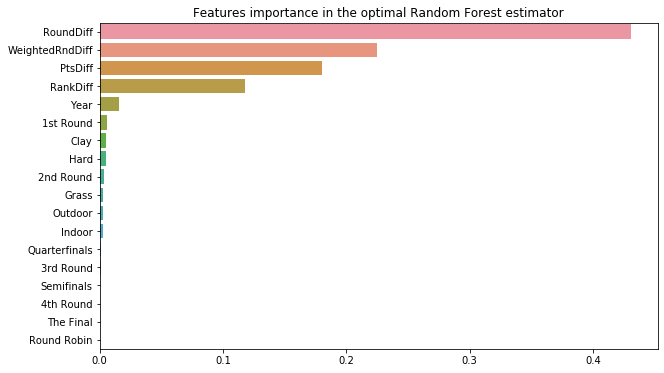

In [167]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.title('Features importance in the optimal Random Forest estimator')

In [168]:
bestPredictions = best_rf.predict(TestX)

In [169]:
bestPredictions = bestPredictions.reshape((len(bestPredictions),1))

In [170]:
trueValues = np.array(TestY).reshape((len(TestY),1))

In [171]:
confusion_matrix(y_pred=bestPredictions, y_true=trueValues)

array([[45, 14],
       [18, 50]])

In [33]:
import pandas as pd  
import os.path as osp
import os
import logging
from glob import glob
import numpy as np
import re   
import plotnine as pln
import numpy as np
import datetime
from matplotlib import pyplot as plt

In [34]:
FILES = sorted(glob("./*.csv*"))

In [35]:
df_atp = pd.concat([pd.read_csv(f) for f in FILES], ignore_index=True,sort=True)

In [36]:
df_atp['Date'] = pd.to_datetime(df_atp['Date'], errors='coerce')

In [37]:
gTest = lambda x: x.year == 2019
gTrain = lambda x: x.year < 2019
testInd = df_atp['Date'].apply(gTest)
trainInd = df_atp['Date'].apply(gTrain)

In [38]:
df_train = df_atp.loc[trainInd].copy()
df_test = df_atp.loc[testInd].copy()

In [81]:
X_train = df_train.drop(["Won","Loser","Winner","Player1","Player2","Series","Tournament","Court","Surface","Unnamed: 0","Round","Date"], axis=1)
y_train = df_train["Won"]

X_test = df_test.drop(["Won","Loser","Winner","Player1","Player2","Series","Tournament","Court","Surface","Unnamed: 0","Round","Date"], axis=1)
y_test = df_test["Won"]

X_train = X_train.fillna(0)
X_test = X_test.fillna(0)
y_train = y_train.fillna(0)
y_test = y_test.fillna(0)

In [82]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from time import time

In [83]:
names = ['Logistic Regression',"Nearest Neighbors", "Decision Tree", "Random Forest", "AdaBoost","Naive Bayes"]

classifiers = [
    LogisticRegression(),
    KNeighborsClassifier(5, n_jobs=-1),
    DecisionTreeClassifier(max_depth=10),
    RandomForestClassifier(max_depth=10, n_estimators=10, n_jobs=-1),
    AdaBoostClassifier(),
    GaussianNB()
]

y_pred = []
train_time = []

for name, clf in zip(names, classifiers):
    tic = time()
    clf.fit(X_train, y_train)
    toc = time()
    
    y_pred.append(clf.predict(X_train))
    train_time.append(toc - tic)
    
    print("Classifier : {} ===> Training duration : {} sec".format(name, train_time[-1]))

/Users/george/Desktop/Anaconda/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier : Logistic Regression ===> Training duration : 0.09934425354003906 sec
Classifier : Nearest Neighbors ===> Training duration : 0.005655050277709961 sec
Classifier : Decision Tree ===> Training duration : 0.0288848876953125 sec
Classifier : Random Forest ===> Training duration : 0.10797286033630371 sec
Classifier : AdaBoost ===> Training duration : 0.4382622241973877 sec
Classifier : Naive Bayes ===> Training duration : 0.0041921138763427734 sec


In [84]:
def find_best_algorithms(y_true, y_pred, name_classifiers, train_time=None):
    assert(len(y_pred) == len(name_classifiers))
    assert(len(train_time) == len(name_classifiers) if train_time else True)
    
    reports = []
    metrics = ["Classifier", "Accuracy", "Precision", "Recall", "F1-Score"]
    if train_time:
        metrics = metrics + ["Training Duration (seconds)"]

    for idx, y_clf in enumerate(y_pred):
        acc = accuracy_score(y_true, y_clf)
        pre = precision_score(y_true, y_clf)
        rec = recall_score(y_true, y_clf)
        f1s = f1_score(y_true, y_clf)
        report = (name_classifiers[idx], acc, pre, rec, f1s)
        if train_time:
            report = report + (train_time[idx], )
        reports.append(report)
            
    display(pd.DataFrame.from_records(reports, columns=metrics))

In [85]:
y_test_pred = []

for name, clf in zip(names, classifiers):
    y_test_pred.append(clf.predict(X_test))
find_best_algorithms(y_test, y_test_pred, names)

,Classifier,Accuracy,Precision,Recall,F1-Score
0,Logistic Regression,0.582677,0.577320,0.823529,0.678788
1,Nearest Neighbors,0.992126,1.000000,0.985294,0.992593
2,Decision Tree,0.637795,0.689655,0.588235,0.634921
3,Random Forest,0.874016,0.882353,0.882353,0.882353
4,AdaBoost,0.559055,0.642857,0.397059,0.490909
5,Naive Bayes,0.708661,0.762712,0.661765,0.708661


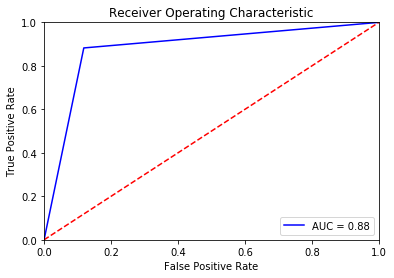

In [90]:
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# RANDOM FOREST

In [121]:
# Create the RandomForest Classifier with gini and fit the training data
forest_gini = RandomForestClassifier(n_jobs=2,n_estimators=100,criterion = "gini")
forest_gini.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=2,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [122]:
# Create the RandomForest Classifier with entropy and fit the training data
forest_entropy = RandomForestClassifier(n_jobs=2,n_estimators=100,criterion = "entropy")
forest_entropy.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=2,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [123]:
score_gini = forest_gini.score(X_test, y_test)
score_entropy = forest_entropy.score(X_test, y_test)

print(f"The score for the RandomForestClassifier with gini: {score_gini}")
print(f"The score for the RandomForestClassifier with entropy: {score_entropy}")

forest = forest_gini  if score_gini > score_entropy else forest_entropy

print(forest.score(X_test, y_test))

The score for the RandomForestClassifier with gini: 0.8267716535433071
The score for the RandomForestClassifier with entropy: 0.8503937007874016
0.8503937007874016


In [124]:
preds = forest.predict(X_test)
pd.crosstab(y_test, preds, rownames=['Actual Wins'],colnames=['Predicted Wins'])

Predicted Wins,0,1
Actial Wins,,
0,51,8
1,11,57


# REGRESSION

In [126]:
import warnings
warnings.simplefilter(action='ignore')

# Adding regresion
regr = LogisticRegression(max_iter=2000)

regr.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=2000,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [127]:
regr.score(X_test, y_test)

0.5826771653543307

In [128]:
preds = regr.predict(X_test)
pd.crosstab(y_test, preds, rownames=['Actual Wins'],colnames=['Predicted Wins'])

Predicted Wins,0,1
Actial Wins,,
0,18,41
1,12,56


# KNN

In [129]:
import math

neigh = KNeighborsClassifier(n_neighbors= int(math.sqrt(len(X_test))))
neigh.fit(X_train,y_train)


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=11, p=2,
                     weights='uniform')

In [132]:
neigh.score(X_train, y_train)

0.9903097092912787

In [135]:
preds = neigh.predict(X_test)
pd.crosstab(y_test, preds, rownames=['Actual Wins'],colnames=['Predicted Wins'])

Predicted Wins,0,1
Actial Wins,,
0,58,1
1,1,67


# DecisionTreeClassifier

In [137]:
decTree = DecisionTreeClassifier(max_depth=10)

In [138]:
decTree.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [139]:
preds = decTree.predict(X_test)

In [140]:
pd.crosstab(y_test, preds, rownames=['Actual Wins'],colnames=['Predicted Wins'])

Predicted Wins,0,1
Actial Wins,,
0,41,18
1,28,40


# AdaBoost

In [141]:
adaBoost = AdaBoostClassifier()
adaBoost.fit(X_train,y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)

In [142]:
adaBoost.score(X_test, y_test)

0.5590551181102362

In [143]:
preds = adaBoost.predict(X_test)
pd.crosstab(y_test, preds, rownames=['Actual Wins'],colnames=['Predicted Wins'])

Predicted Wins,0,1
Actial Wins,,
0,44,15
1,41,27


# NAIVE BAYSE

In [144]:
nv = GaussianNB()
nv.fit(X_train,y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [145]:
nv.score(X_test, y_test)

0.7086614173228346

In [146]:
preds = nv.predict(X_test)
pd.crosstab(y_test, preds, rownames=['Actual Wins'],colnames=['Predicted Wins'])

Predicted Wins,0,1
Actial Wins,,
0,45,14
1,23,45


# Feature Importance and Feature Selection
- Feature importance can computed by accumulating the loss reduction achieved by the corresponding nodes across the forest.

- Scikit-learn provides a normalized (sums to 1) feature importance score

- Let's evaluate the goodness of the model when using only a subset of the features available.

In [242]:
from sklearn.utils import resample
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
X = X_test
y = y_test

print (X.shape)
print (y.shape)
print (df_test.columns)

(127, 12)
(127,)
Index(['Best of', 'Court', 'Date', 'LPts', 'LRank', 'Loser', 'Player1',
       'Player2', 'PtsDiff', 'RankDiff', 'Round', 'RoundDiff', 'Series',
       'Surface', 'Tournament', 'Unnamed: 0', 'WPts', 'WRank',
       'WeightedRndDiff', 'Winner', 'Won', 'Wp1Vsp2', 'Year', 'p1Vsp2'],
      dtype='object')


In [243]:
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X,y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [244]:
rf.feature_importances_

array([0.        , 0.09705846, 0.08405757, 0.17362644, 0.12552842,
       0.23283716, 0.09705164, 0.10483323, 0.06703089, 0.01235999,
       0.        , 0.0056162 ])

Text(0.5, 1.0, 'Feature Importances')

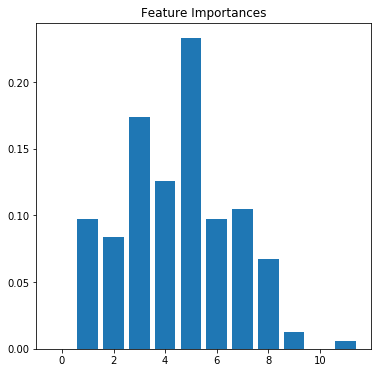

In [247]:
fig, ax = plt.subplots(figsize=(6,6))
ax.bar(range(0,X.shape[1]), rf.feature_importances_)
ax.set_title("Feature Importances")

# Recursive Elimination

- The ranking might be affected by feature interactions (e.g., dependencies, or correlations)

- We can apply the above ranking and selection recursively:
  - Build a Random Forest
  - Discard a few low scored features
  - Repeat
  

In [251]:
from sklearn.feature_selection import RFE

rf_small = RandomForestRegressor(n_estimators=100)
selector = RFE(rf_small, 
                 step=1, # features removed at each step
                 n_features_to_select=1 # selected features
                )
selector.fit(X,y)

RFE(estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                    max_depth=None, max_features='auto',
                                    max_leaf_nodes=None,
                                    min_impurity_decrease=0.0,
                                    min_impurity_split=None, min_samples_leaf=1,
                                    min_samples_split=2,
                                    min_weight_fraction_leaf=0.0,
                                    n_estimators=100, n_jobs=None,
                                    oob_score=False, random_state=None,
                                    verbose=0, warm_start=False),
    n_features_to_select=1, step=1, verbose=0)

In [252]:
np.argsort(selector.ranking_)

array([ 5,  3,  1,  7,  4,  6,  2,  8,  9, 11, 10,  0])

In [255]:
selector.score(X_test,y_test)

0.8355053358227472

# Recursive feature elimination with cross-validation

Optimal number of features : 7


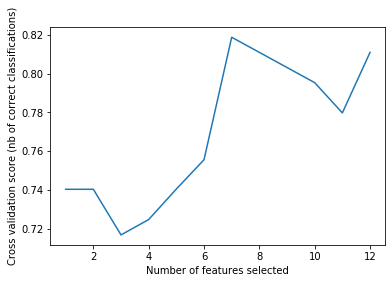

In [257]:
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification
svc = SVC(kernel="linear")
rfecv = RFECV(estimator=svc, step=1, cv=StratifiedKFold(2),
              scoring='accuracy')
rfecv.fit(X, y)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

The best accuracy is around 95 percent. From my point of view is pretty decent. The nature of the problem is not an ordinary ML task since it includes the Time factor that I did not explore using time series techniques. I have not used betting data because it’s the output of other people models, and it does not make sense to use it and pretend having built a realistic ML Model.